In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the Dtaset
df = pd.read_csv("DailyDelhiClimate.csv")
# Display the first few rows of the dataset
df.head()

date   meantemp   humidity  wind_speed  meanpressure
0  1/1/2013  10.000000  84.500000    0.000000   1015.666667
1  1/2/2013   7.400000  92.000000    2.980000   1017.800000
2  1/3/2013   7.166667  87.000000    4.633333   1018.666667
3  1/4/2013   8.666667  71.333333    1.233333   1017.166667
4  1/5/2013   6.000000  86.833333    3.700000   1016.500000

In [3]:
# Check for any missing values in the dataset
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [4]:
# Describe the dataset statistically
df.describe()

meantemp     humidity  wind_speed  meanpressure
count  1575.000000  1575.000000  1575.00000   1575.000000
mean     25.227828    60.429087     6.90190   1011.197364
std       7.343597    16.973286     4.51094    173.648628
min       6.000000    13.428571     0.00000     -3.041667
25%      18.516667    49.750000     3.70000   1001.875000
50%      27.166667    62.380952     6.37000   1009.111111
75%      31.142857    72.125000     9.26250   1015.200000
max      38.714286   100.000000    42.22000   7679.333333

In [5]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# Sort by date to ensure correct time sequence
df = df.sort_values('date')

# Set the date as index
df.set_index('date', inplace=True)

# Display the date range and total number of records
df.index.min(), df.index.max(), len(df)

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-04-24 00:00:00'), 1575)

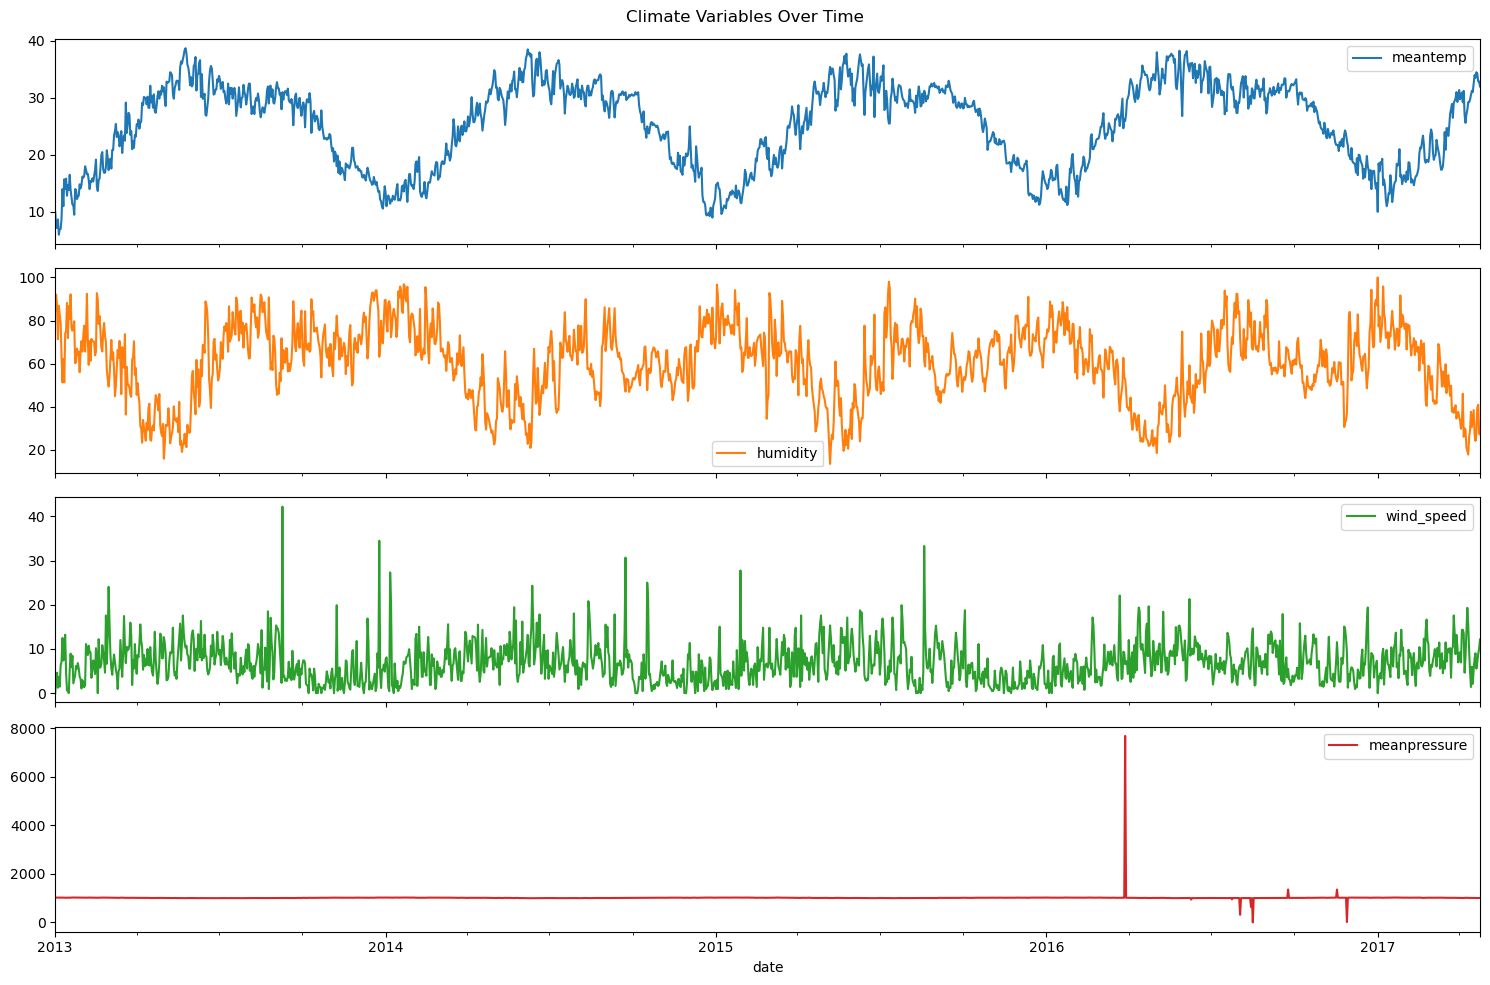

In [6]:
# Plot each feature
df.plot(subplots=True, figsize=(15, 10), title='Climate Variables Over Time')
plt.tight_layout()
plt.show()

In [7]:
# Using Z-score method
from scipy.stats import zscore

z_scores = zscore(df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
outliers = (abs(z_scores) > 3).sum()
print("Outliers per column:\n", outliers)

Outliers per column:
 18


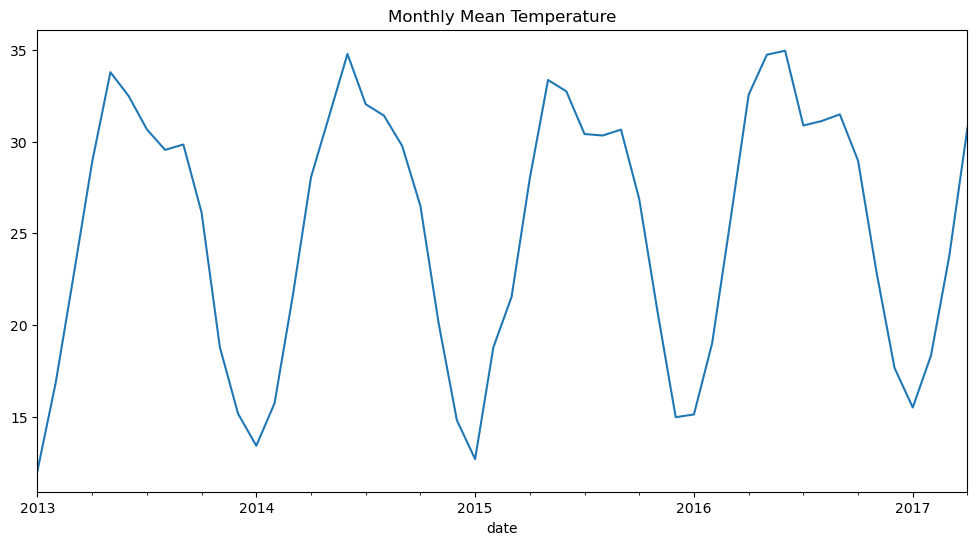

In [8]:
# Monthly mean temperature
monthly_df = df['meantemp'].resample('M').mean()
monthly_df.plot(title='Monthly Mean Temperature', figsize=(12,6))
plt.show()

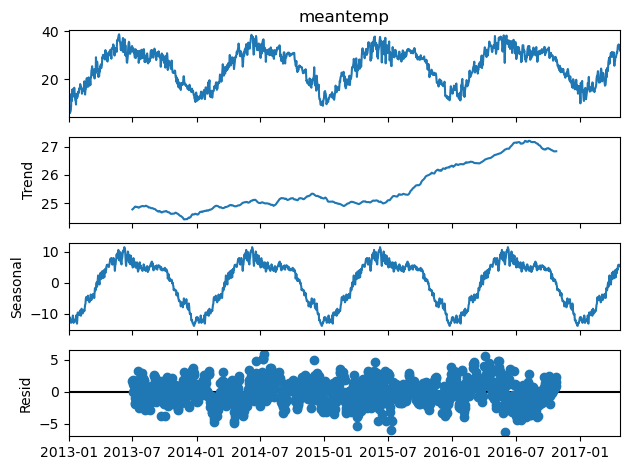

In [9]:
# Decompose the temperature data
result = seasonal_decompose(df['meantemp'], model='additive', period=365)
result.plot()
plt.show()

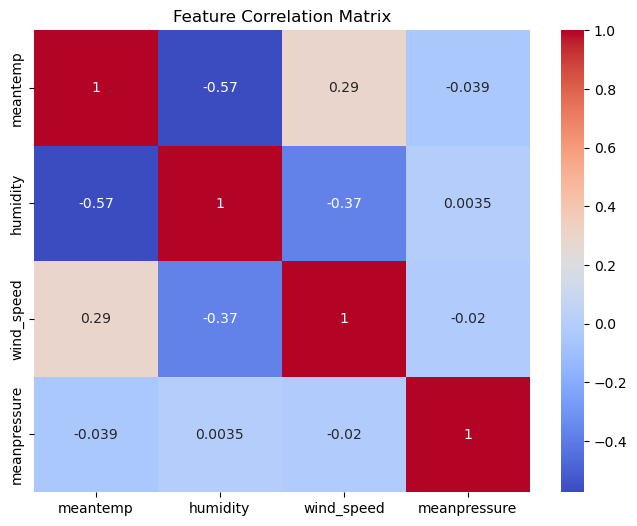

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [11]:
# Perform ADF test
adf_result = adfuller(df['meantemp'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -2.377592279031286
p-value: 0.14816094866398516


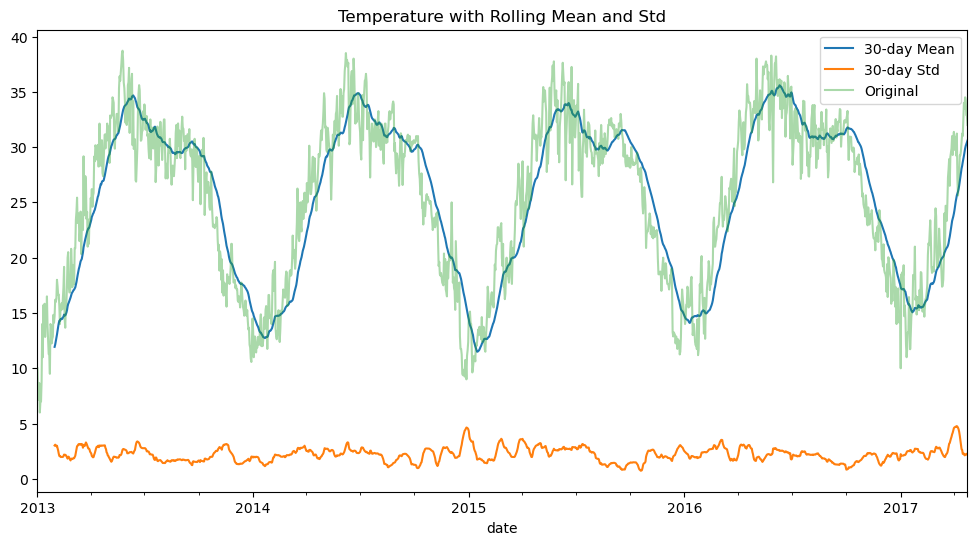

In [12]:
# 30-day rolling mean and standard deviation
df['meantemp'].rolling(window=30).mean().plot(label='30-day Mean', figsize=(12,6))
df['meantemp'].rolling(window=30).std().plot(label='30-day Std')
df['meantemp'].plot(label='Original', alpha=0.4)
plt.legend()
plt.title("Temperature with Rolling Mean and Std")
plt.show()

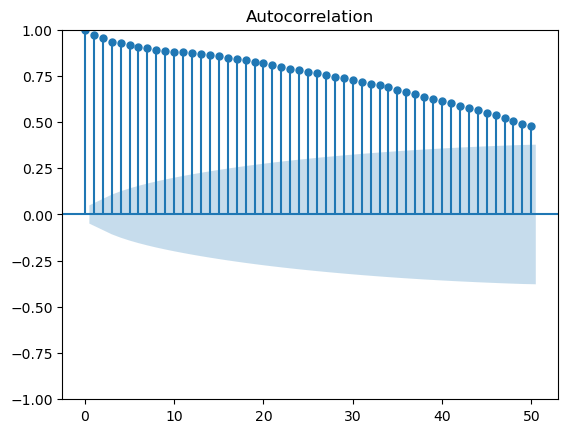

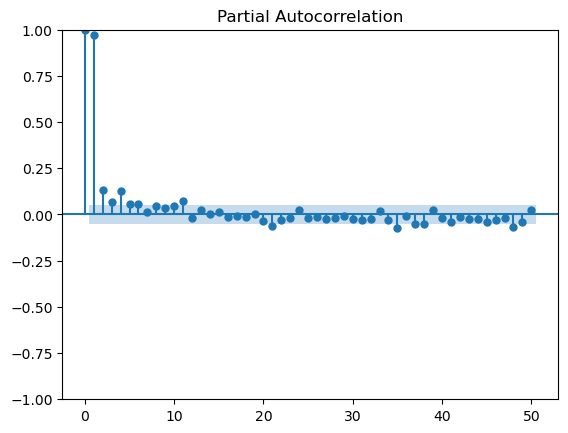

In [13]:
plot_acf(df['meantemp'], lags=50)
plt.show()

plot_pacf(df['meantemp'], lags=50)
plt.show()

In [14]:
from statsmodels.tsa.stattools import kpss

# KPSS test on the 'meantemp' series
stat, p_value, lags, crit_vals = kpss(df['meantemp'].dropna(), regression='c')

print("KPSS Statistic:", stat)
print("p-value:", p_value)
print("Critical Values:")
for key, value in crit_vals.items():
    print(f"   {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("\n⚠️ The series is likely non-stationary (reject the null hypothesis).")
else:
    print("\n✅ The series is likely stationary (fail to reject the null hypothesis).")


KPSS Statistic: 0.11413076364012856
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

✅ The series is likely stationary (fail to reject the null hypothesis).


In [15]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [16]:
# Use only 'meantemp' for univariate time series prediction
temperature_data = df[['meantemp']].copy()

# Normalize the temperature data
scaler = MinMaxScaler()
temperature_scaled = scaler.fit_transform(temperature_data)

# Convert to sequences suitable for RNN
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size (e.g., past 30 days to predict next day)
window_size = 30
X, y = create_sequences(temperature_scaled, window_size)

# Indices for 3 months (90 days) and 1 year (365 days)
test_days_3mo = 90
test_days_1yr = 365

# Create train-test splits
X_train_3mo, y_train_3mo = X[:-test_days_3mo], y[:-test_days_3mo]
X_test_3mo, y_test_3mo = X[-test_days_3mo:], y[-test_days_3mo:]

X_train_1yr, y_train_1yr = X[:-test_days_1yr], y[:-test_days_1yr]
X_test_1yr, y_test_1yr = X[-test_days_1yr:], y[-test_days_1yr:]

X.shape, X_train_3mo.shape, X_test_3mo.shape, X_train_1yr.shape, X_test_1yr.shape

((1545, 30, 1), (1455, 30, 1), (90, 30, 1), (1180, 30, 1), (365, 30, 1))

# Simple RNN Model 

## 3 months Prediction

In [17]:
def build_rnn_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [19]:
model = build_rnn_model((X_train_3mo.shape[1], X_train_3mo.shape[2]))
history = model.fit(
    X_train_3mo,
    y_train_3mo,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_3mo, y_test_3mo),
    verbose=1
)


Epoch 1/20
46/46 [==============================] - 3s 32ms/step - loss: 0.0861 - val_loss: 0.0064
Epoch 2/20
46/46 [==============================] - 1s 22ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 3/20
46/46 [==============================] - 1s 24ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 4/20
46/46 [==============================] - 1s 27ms/step - loss: 0.0046 - val_loss: 0.0074
Epoch 5/20
46/46 [==============================] - 1s 21ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 6/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0043 - val_loss: 0.0061
Epoch 7/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 8/20
46/46 [==============================] - 1s 26ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 9/20
46/46 [==============================] - 1s 22ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 10/20
46/46 [==============================] - 1s 22ms/step - loss: 0.0039 - val_loss: 0.0054
Epoch 11/

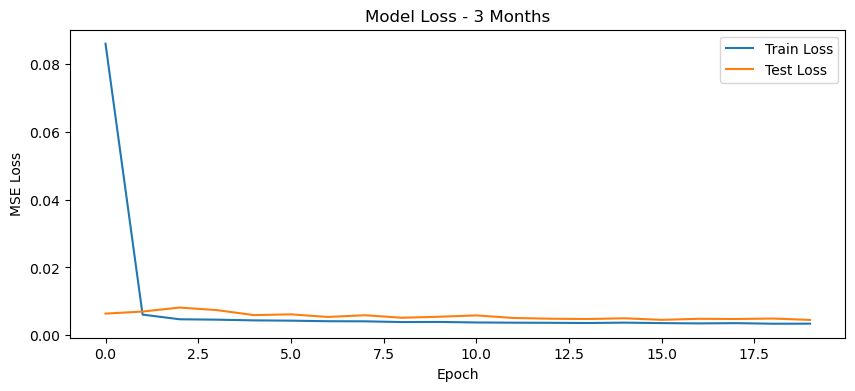

In [20]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title(f'Model Loss - 3 Months')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

3/3 [==============================] - 0s 7ms/step


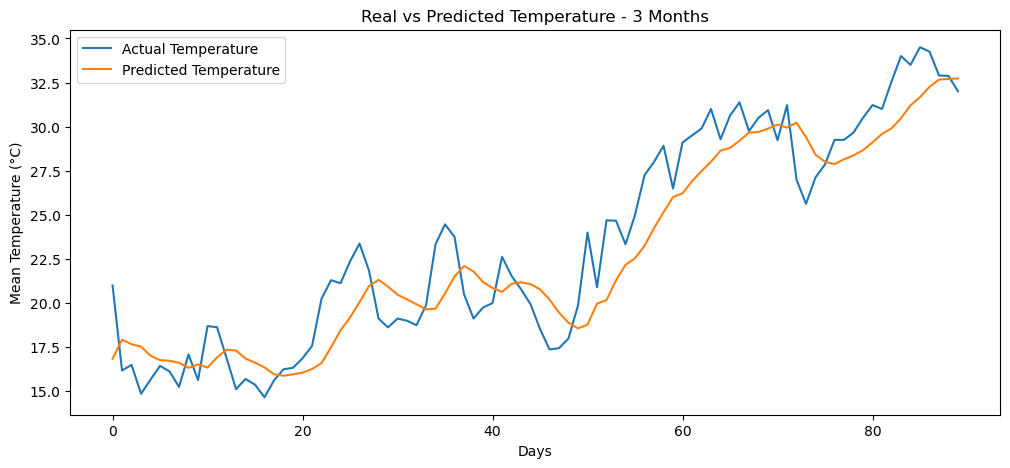

In [21]:
# Predict and inverse scale
y_pred = model.predict(X_test_3mo)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test_3mo)

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.title(f'Real vs Predicted Temperature - 3 Months')
plt.xlabel('Days')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

In [22]:
# Compute metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print("3 Months Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

3 Months Evaluation Metrics:
MAE: 1.844
RMSE: 2.191
MAPE: 8.11%


## 1 Year Prediction

In [23]:
model = build_rnn_model((X_train_1yr.shape[1], X_train_1yr.shape[2]))
history = model.fit(
    X_train_1yr,
    y_train_1yr,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_1yr, y_test_1yr),
    verbose=1 
)

Epoch 1/20
37/37 [==============================] - 3s 38ms/step - loss: 0.1592 - val_loss: 0.0135
Epoch 2/20
37/37 [==============================] - 1s 22ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 4/20
37/37 [==============================] - 1s 27ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 5/20
37/37 [==============================] - 1s 24ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 6/20
37/37 [==============================] - 1s 25ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 7/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 9/20
37/37 [==============================] - 1s 30ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 10/20
37/37 [==============================] - 1s 23ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 11/

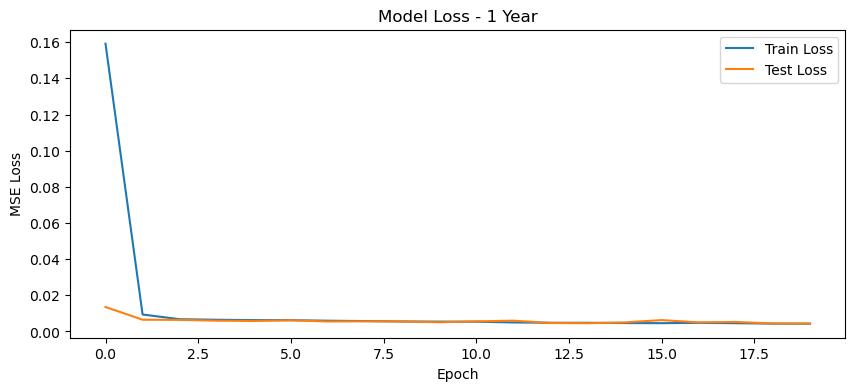

In [24]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title(f'Model Loss - 1 Year')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

12/12 [==============================] - 0s 9ms/step


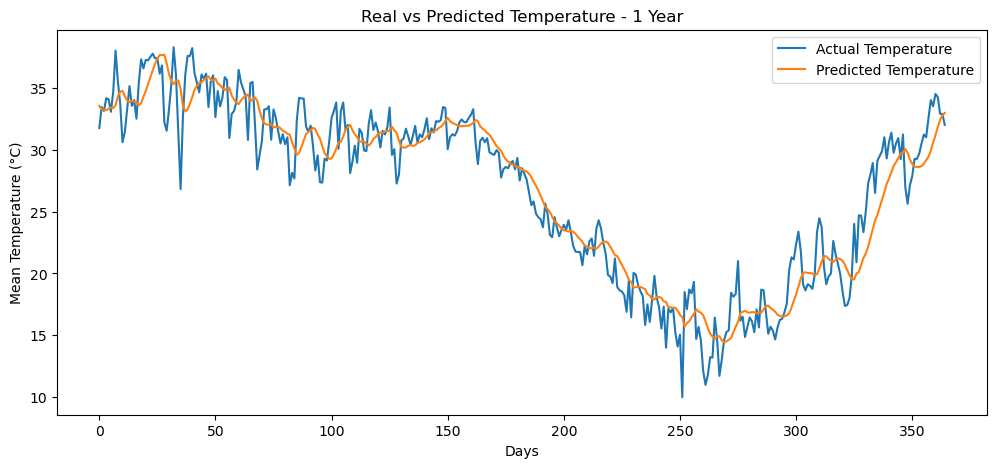

In [25]:
# Predict and inverse scale
y_pred = model.predict(X_test_1yr)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform( y_test_1yr)

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.title(f'Real vs Predicted Temperature - 1 Year')
plt.xlabel('Days')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

In [26]:
# Compute metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print("1 Year Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

1 Year Evaluation Metrics:
MAE: 1.673
RMSE: 2.167
MAPE: 6.97%


# Advanced RNN Model

## 3 Months Prediction

In [27]:
def build_advanced_rnn_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model



In [29]:
model = build_advanced_rnn_model((X_train_3mo.shape[1], X_train_3mo.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_3mo, y_train_3mo,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_3mo, y_test_3mo),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
46/46 [==============================] - 9s 89ms/step - loss: 0.0319 - val_loss: 0.0084
Epoch 2/50
46/46 [==============================] - 3s 62ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 3/50
46/46 [==============================] - 2s 49ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 4/50
46/46 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 5/50
46/46 [==============================] - 2s 42ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 6/50
46/46 [==============================] - 2s 52ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 7/50
46/46 [==============================] - 2s 47ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 8/50
46/46 [==============================] - 3s 68ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 9/50
46/46 [==============================] - 2s 47ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 10/50
46/46 [==============================] - 2s 48ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 11/

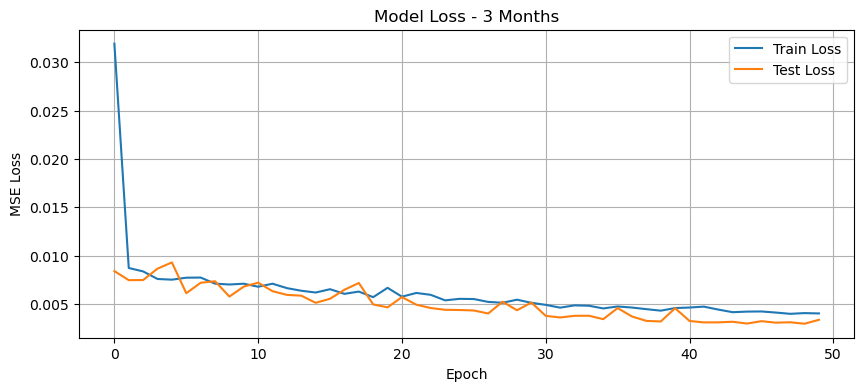

In [30]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title(f'Model Loss - 3 Months')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

3/3 [==============================] - 1s 21ms/step


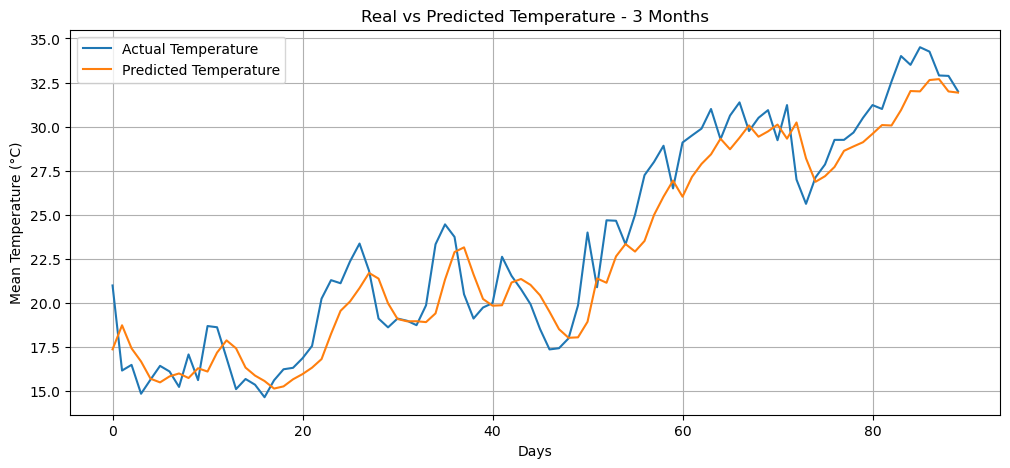

In [31]:
# Predict and inverse scale
y_pred = model.predict(X_test_3mo)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test_3mo)

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.title(f'Real vs Predicted Temperature - 3 Months')
plt.xlabel('Days')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Evaluation metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"3 Months Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

3 Months Evaluation Metrics:
MAE: 1.537
RMSE: 1.900
MAPE: 6.72%


## 1 Year Prediction

In [33]:
model = build_advanced_rnn_model((X_train_1yr.shape[1], X_train_1yr.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_1yr, y_train_1yr,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_1yr, y_test_1yr),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
37/37 [==============================] - 11s 101ms/step - loss: 0.0373 - val_loss: 0.0094
Epoch 2/50
37/37 [==============================] - 2s 53ms/step - loss: 0.0102 - val_loss: 0.0054
Epoch 3/50
37/37 [==============================] - 2s 68ms/step - loss: 0.0088 - val_loss: 0.0053
Epoch 4/50
37/37 [==============================] - 2s 57ms/step - loss: 0.0077 - val_loss: 0.0050
Epoch 5/50
37/37 [==============================] - 2s 57ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 6/50
37/37 [==============================] - 2s 58ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 7/50
37/37 [==============================] - 2s 55ms/step - loss: 0.0075 - val_loss: 0.0048
Epoch 8/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 9/50
37/37 [==============================] - 2s 50ms/step - loss: 0.0074 - val_loss: 0.0057
Epoch 10/50
37/37 [==============================] - 3s 70ms/step - loss: 0.0076 - val_loss: 0.0047
Epoch 1

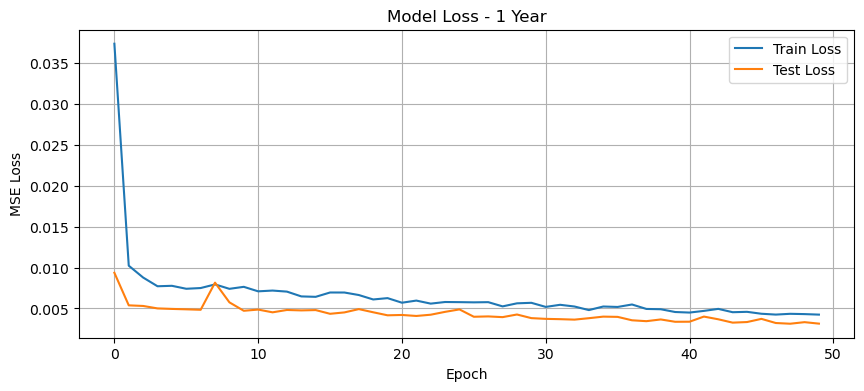

In [34]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title(f'Model Loss - 1 Year')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

12/12 [==============================] - 2s 14ms/step


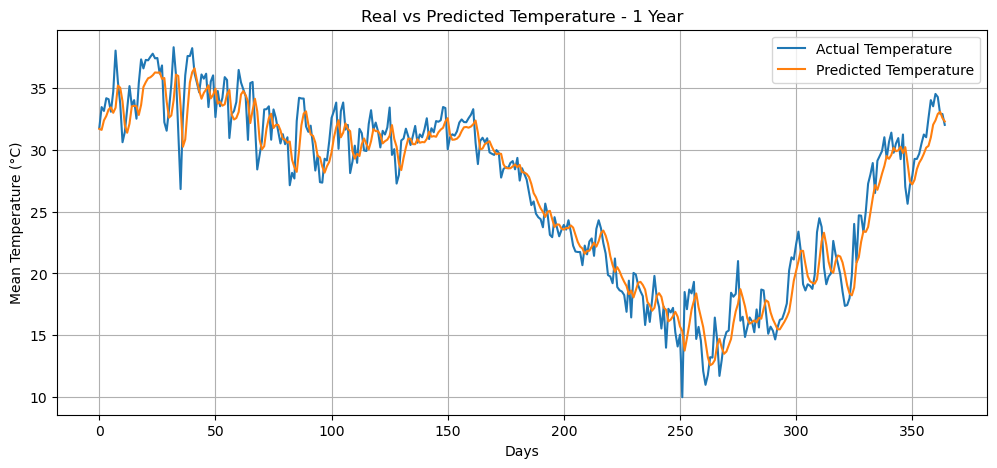

In [35]:
# Predict and inverse scale
y_pred = model.predict(X_test_1yr)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test_1yr)

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.title(f'Real vs Predicted Temperature - 1 Year')
plt.xlabel('Days')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Evaluation metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"1 Year Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

1 Year Evaluation Metrics:
MAE: 1.449
RMSE: 1.836
MAPE: 6.02%
